In [1]:
import os
import pandas as pd

#Specify current working directory
cwd = os.getcwd()

#Identify the datafile in the current working directory and it's filepath
#Read it into a dataframe and add column names to the features
for file in os.listdir(cwd):
    if file.endswith('.csv'):
        print(file)
        filepath = cwd + '\\' + file
        dataset  = pd.read_csv(filepath,na_values='?')


Housing.csv


In [2]:
#Review/check the info of the dataframe
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [3]:
#Have a look at the first few rows of the dataframe
dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
#create html file for pandas profiling of dataset - having a more detailed understanding of the data
#Also identifies possible issues such as missing values

import pandas_profiling
profile = dataset.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="pandas_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 167.02it/s]


In [5]:
#Render the pandas profile within vscode
#profile.to_notebook_iframe()
#Trying again...

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.10.1


In [8]:
#View NA records - these are shown in the pandas profile as well
#There are no NAs in this dataset
dataset.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [9]:
# drop records with null - this is redundant for this dataset
dataset = dataset.dropna()

In [10]:
#area will be the feature used for this univariable regression
#Drop the other columns

dataset.drop(
['bedrooms',
'bathrooms',
'stories',
'mainroad',
'guestroom',
'basement',
'hotwaterheating',
'airconditioning',
'parking',
'prefarea',
'furnishingstatus'],inplace=True, axis=1)

In [11]:
dataset.head()

,price,area
0,13300000,7420
1,12250000,8960
2,12250000,9960
3,12215000,7500
4,11410000,7420


In [12]:
#Create a training and test datasets that are exclusive of eachother
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [13]:
#Summary of descriptive stats for training dataset
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,436.0,4.767705e+06,1.888795e+06,1750000.0,3430000.0,4340000.0,5740000.0,12250000.0
area,436.0,5.190005e+03,2.229190e+03,1650.0,3580.5,4636.0,6420.0,16200.0


In [14]:
train_dataset.head()

,price,area
239,4585000,4000
113,6083000,9620
325,4007500,3460
66,6930000,13200
479,2940000,3660


In [15]:
#Create a list of training and test dataset features 
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#Remove the outcome variable 'MPG' (the label) from the feature datasets 
train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

In [16]:
train_labels

239    4585000
113    6083000
325    4007500
66     6930000
479    2940000
        ...   
419    3360000
62     7070000
478    2940000
377    3640000
130    5866000
Name: price, Length: 436, dtype: int64

In [17]:
test_labels

0      13300000
9       9800000
23      8645000
28      8400000
31      8400000
         ...   
515     2450000
517     2450000
529     2275000
530     2240000
538     1890000
Name: price, Length: 109, dtype: int64

In [18]:
#Summary of select descriptive stats from train_dataset
#Observe that features have substiantlly different scales and ranges
#This can cause issues/inefficiencies with training/optimising the model
#Specifically - varying scales can interfere with the weightings/gradients
#With some features being dominated and others dominating - interfering with the model

train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
price,4.767705e+06,1.888795e+06
area,5.190005e+03,2.229190e+03


In [19]:
#Normalization of data is a simple best practice to manage the issues related to variables of different scales
#The step below create a layer to assist with normalizing data
#In this case - normalising a bunch of categorical fields... but doens't really matter? - we won't use them
normalizer = tf.keras.layers.Normalization(axis=-1)

In [20]:
#Then run the train_features dataset through the normalizer layer to calculate the mean and variance of the dataset
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization#adapt
normalizer.adapt(np.array(train_features))

In [21]:
#View the train_features feature means returned as an array
normalizer.mean.numpy()

array([[5190.005]], dtype=float32)

In [22]:
train_features.head()

,area
239,4000
113,9620
325,3460
66,13200
479,3660


In [23]:
#Return the first row of the train_features dataset as first
first = np.array(train_features[:1])
first

array([[4000]], dtype=int64)

In [24]:
#Run the first row through the normalizer layer to normalize it  - produce the normalized output
#Comparing this output to above shows how the values have been normalized
normalizer(first).numpy()

array([[-0.534]], dtype=float32)

In [25]:
#Linear regression with a single variable

#Create the training dataset with only the Horsepower feature
area = np.array(train_features['area'])

area_normalizer = layers.Normalization(input_shape=[1,], axis=None)
area_normalizer.adapt(area)


In [26]:
area_model = tf.keras.Sequential([
    area_normalizer,
    layers.Dense(units=1)
])
area_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [27]:
area_model.predict(area[:10])

1/1 [==============================] - 0s 73ms/step


array([[ 0.733],
       [-2.727],
       [ 1.065],
       [-4.932],
       [ 0.942],
       [-0.714],
       [ 0.825],
       [ 1.053],
       [ 1.033],
       [-2.346]], dtype=float32)

In [28]:
area_model.compile(
    #Learning rate parameter was initially set too low from previous model
    #This was observed by the the plot 'plot_loss(history)' below where the error wasn't converging/improving quickly enough over each epoch
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    
    #Tinkering with the learning rate then setting it to high, where the error was now erratic, overshooting in either direction over each epoch.
    #In this case... the change in error between each epoch was a large relative to the average price of houses (percentage)
    #optimizer=tf.keras.optimizers.Adam(learning_rate=1e10),

    #Finding a bit more of a sweet spot for this parameter where the error converged
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e4),
    loss='mean_absolute_error')

In [29]:
%%time
history = area_model.fit(
    train_features['area'],
    train_labels,
    epochs=100,
    # Suppress logging.
    #verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 4697317.0000 - val_loss: 4742794.5000
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 4586828.0000 - val_loss: 4632822.5000
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 4477608.5000 - val_loss: 4523257.0000
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 4367278.5000 - val_loss: 4412912.5000
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 4257088.5000 - val_loss: 4302913.5000
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 4147049.2500 - val_loss: 4193199.2500
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 4036822.7500 - val_loss: 4083260.2500
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 3926719.0000 - val_loss: 3973215.7500
Epoch 9/100
11/11 [==============================] - 0s 3ms/step - loss: 3817743.5000 - val_loss: 3862855.7500


In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,1140789.375,1286243.375,95
96,1140672.875,1286127.875,96
97,1141368.000,1286670.875,97
98,1141852.875,1286227.375,98
99,1140980.500,1286562.125,99


In [31]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [area]')
  plt.legend()
  plt.grid(True)

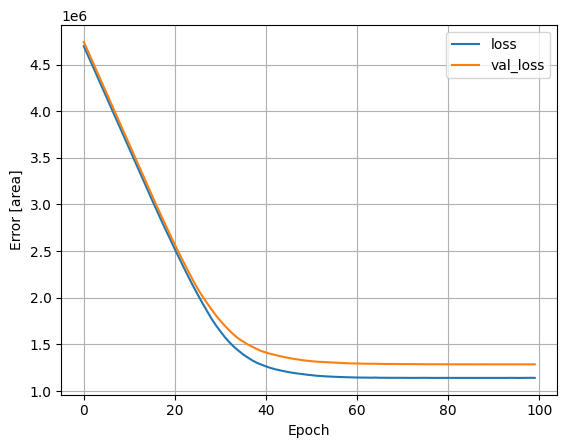

In [32]:
plot_loss(history)
#The units of the error y axis, for each epoch, is the average absolute error of price (dollars)
#loss is the error with respect with training data that the model was trainder on
#val_loss is the error with respect to validation data
#Would expect the error of val_loss to be higher than loss, as the model wasn't trained on validation data
#Initially the learning rate for the model was set too low and the model wasn't improving anywhere near quick enough over each epoch
#Then the learning rate was set too high and was overshooting in either direction - very erratic
#Then the learning rate was set to a sweet spot and yielded a good result
#An indication that the it hasn't had enough time is if the curve is still declining, it hasn't found the optimal model.
#Would need more epochs or edits to the learning rate

In [33]:
test_results = {}

test_results['area_model'] = area_model.evaluate(
    test_features['area'],
    test_labels, verbose=0)

In [34]:
x = tf.linspace(0.0, 16000, 251)
y = area_model.predict(x)

8/8 [==============================] - 0s 785us/step


In [35]:
def plot_area(x, y):
  plt.scatter(train_features['area'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('area')
  plt.ylabel('price')
  plt.legend()

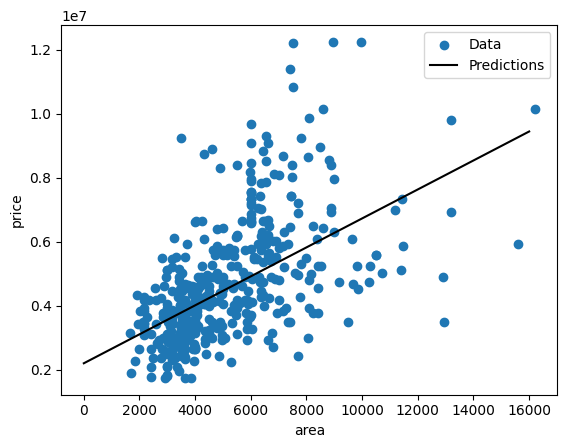

In [36]:
plot_area(x, y)
#In this model, which is a linear model for a single input, the network would have a single weighting for input layer x and a single output neuron in the next layer for y
#y=mx+c m as the weighting 'm' for input 'x' output 'y'
#Seems like tensorflow is intended for deeper neaural networks, since some features that are not applicable to deeper networks are not available
#For example, I'd like to extract the equation for the model, the coefficients and constant, but this doesn't seem readily doable